# Setup

In [30]:
import pandas as pd
import numpy as np
import warnings 

from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns 

pd.set_option('display.max_columns', None)

In [31]:
data_path = r"C:\Users\caleb\PycharmProjects\security_project\security_project\Data\extended_dike_modeling.p"

## Functions

In [32]:
def set_label(vec, grouping = "generic"):
    # If include_generic is True then we allow the usage of the "generic" label for malicious files
    # Otherwise, we exclude the generic label
    
    return_value = None
    if vec[0] == "benign":
        return_value = "benign"
    else:
        # Use the labels provided in the Dike dataset
        if grouping == "raw":
            possible_labels = vec[1:]
            lookup_dic = {
                0:"generic",
                1:"trojan",
                2:"ransomware",
                3:"worm",
                4:"backdoor",
                5:"spyware",
                6:"rootkit",
                7:"encrypter",
                8:"downloader"
            }
        # If the file is trojan, label as trojan. Otherwise, label as generic
        elif grouping == "generic":
            possible_labels = vec[1:]
            lookup_dic = {
                0:"generic",
                1:"trojan",
                2:"generic",
                3:"generic",
                4:"generic",
                5:"generic",
                6:"generic",
                7:"generic",
                8:"generic"
            }  
        # Use raw labels but exclude generic label when calculating classification
        elif grouping == "exclude_generic":
            possible_labels = vec[2:]
            lookup_dic = {
                0:"trojan",
                1:"ransomware",
                2:"worm",
                3:"backdoor",
                4:"spyware",
                5:"rootkit",
                6:"encrypter",
                7:"downloader"
            }            
            
        index_max = max(range(len(possible_labels)), key=possible_labels.__getitem__)
        
        return_value = lookup_dic[index_max]
            
    return return_value

# Pull in Data & Clean

In [33]:
base_df = pd.read_pickle(data_path)

In [34]:
base_df["label"] = base_df[["source","generic","trojan","ransomware","worm","backdoor","spyware","rootkit","encrypter","downloader"]].apply(set_label, grouping = "raw", axis=1)

In [35]:
base_df.groupby("label")["hash"].nunique()

label
benign      962
generic    1770
trojan     4238
worm          8
Name: hash, dtype: int64

In [36]:
# These are columns we determined we could drop in Modeling.ipynb
modeling_data = base_df.drop(columns=[
    "source","type","ID","VersionInformationSize","legitimate","malice"
    ,"generic","trojan","ransomware","worm","backdoor","spyware","rootkit","encrypter","downloader","md5"
])

In [37]:
modeling_data = modeling_data.rename(columns={
    "hash":"hash_ID"
})

In [38]:
modeling_data["is_malicious"] = np.where(
    modeling_data["label"] == "benign"
    ,False
    ,True
)

In [39]:
modeling_data.shape

(6978, 56)

In [40]:
modeling_data.head()

,hash_ID,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,label,is_malicious
0,012a50629c3cf1e2a2e5133b729c2ac7765cf4115187b1...,332,224,271,6,0,36864,380928,0,5616,4096,40960,4194304,4096,4096,4,0,0,0,4,0,823296,4096,0,2,0,1048576,4096,1048576,4096,0,16,4,4.804751,0.707497,7.904654,104448.0,8192,360448,202528.5,14300,402506,4,62,0,0,5,3.041344,1.781496,6.505338,963.6,20,4264,0,trojan,True
1,018b4029f46e529da8dc57b8bc6245644ed59f63b4f8ea...,332,224,271,7,0,24576,420539,397312,6469,4096,28672,4259840,4096,4096,4,0,0,0,4,0,856064,4096,518968,2,0,1048576,4096,1048576,4096,0,16,4,5.768973,2.662357,7.637939,112640.0,16384,376832,211277.5,20756,415160,5,85,0,0,4,5.667223,1.919241,7.95996,8029.5,20,16936,0,generic,True
2,01a0bea806384827759ae032031516bfe843285cac3980...,332,224,271,7,0,20480,390466,430080,5873,4096,24576,4259840,4096,4096,4,0,0,0,4,0,856064,4096,437261,2,0,1048576,4096,1048576,4096,0,16,4,7.212979,6.636076,7.876911,104448.0,20480,262144,210782.75,20164,532664,4,63,0,0,4,5.648782,1.919241,7.961305,7916.75,20,16936,0,generic,True
3,01a795638fe5829264455b8efe4c1dbb52d74b8fadf17c...,332,224,271,6,0,36864,380928,0,5616,4096,40960,4194304,4096,4096,4,0,0,0,4,0,823296,4096,0,2,0,1048576,4096,1048576,4096,0,16,4,4.804191,0.709834,7.904686,104448.0,8192,360448,202528.5,14300,402506,4,62,0,0,5,3.040498,1.781496,6.501108,963.6,20,4264,0,trojan,True
4,01ca2135cdc41c49a873dbcb4299658480b85475b43ca5...,332,224,8450,8,0,143360,61440,0,77738,4096,147456,1677721600,4096,4096,4,0,0,0,4,0,225280,4096,268692,2,320,1048576,4096,1048576,4096,0,16,5,4.640248,2.597247,6.644364,40960.0,4096,143360,41468.8,1364,139980,7,114,0,2,5,2.530489,1.078755,4.655421,206.8,44,748,72,generic,True


# Clustering

In [41]:
modeling_data["label"].unique()

array(['trojan', 'generic', 'worm', 'benign'], dtype=object)

In [42]:
cluster_data = modeling_data.drop(columns=["hash_ID","label","is_malicious"])

## KMeans

### Use Elbow Method 

In [43]:
WCSS = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=1202)
    kmeans.fit(cluster_data)
    outputs.append(kmeans.inertia_)

In [44]:
plt.plot(range(1, 11), WCSS)

In [45]:
plt.title('Selecting the Numbeer of Clusters using the Elbow Method')

Text(0.5, 1.0, 'Selecting the Numbeer of Clusters using the Elbow Method')

In [46]:
plt.xlabel('Clusters')
plt.ylabel('WCSS')
plt.show()

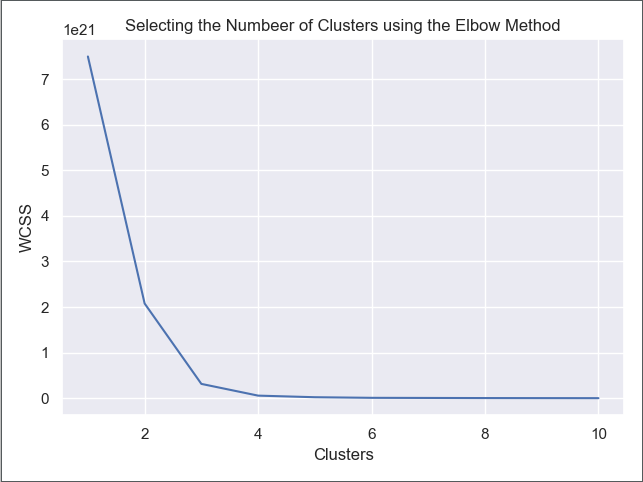

### Cluster

In [50]:
kmeans = KMeans(n_clusters=3, random_state=1202)

In [51]:
modeling_data['kmeans_cluster'] = kmeans.fit_predict(modeling_data[list(cluster_data.columns.values)])

In [52]:
modeling_data.groupby(["kmeans_cluster","label"])["hash_ID"].nunique().reset_index(name="Count")

,kmeans_cluster,label,Count
0,0,benign,754
1,0,generic,1379
2,0,trojan,3924
3,0,worm,8
4,1,benign,208
5,2,generic,391
6,2,trojan,314


## SpectralClustering

In [14]:
%%time
warnings.filterwarnings("ignore")
outputs = []
for i in range(2,5):
    for j in range(1,11):
        spectral_cluster_model= SpectralClustering(
            n_clusters=i, 
            random_state=1202, 
            n_neighbors=j, 
            affinity='nearest_neighbors'
        ) 
        modeling_data['spectral_cluster'] = spectral_cluster_model.fit_predict(modeling_data[list(cluster_data.columns.values)])
        outputs.append([f"i={i},j={j}"
                       ,modeling_data.groupby(["spectral_cluster","label"])["hash_ID"].nunique().reset_index(name="Count")
                      ]
                     )

Wall time: 2min 4s


In [16]:
len(outputs)

30

In [18]:
outputs

[['i=2,j=1',
     cluster    label  Count
  0        0   benign    962
  1        0  generic   1679
  2        0   trojan   3920
  3        0     worm      8
  4        1  generic     91
  5        1   trojan    318],
 ['i=2,j=2',
     cluster    label  Count
  0        0   benign    414
  1        0  generic    701
  2        0   trojan   1708
  3        0     worm      1
  4        1   benign    548
  5        1  generic   1069
  6        1   trojan   2530
  7        1     worm      7],
 ['i=2,j=3',
     cluster    label  Count
  0        0   benign    517
  1        0  generic    920
  2        0   trojan   2190
  3        0     worm      7
  4        1   benign    445
  5        1  generic    850
  6        1   trojan   2048
  7        1     worm      1],
 ['i=2,j=4',
     cluster    label  Count
  0        0   benign    750
  1        0  generic   1275
  2        0   trojan   2769
  3        0     worm      8
  4        1   benign    212
  5        1  generic    495
  6        1  

In [15]:
fig, ax = plt.subplots()
modeling_data.plot.bar(x='cluster', y='Spending Score (1-100)', data=X, hue='cluster', ax=ax)
ax.set(title='Spectral Clustering')

NameError: name 'plt' is not defined